In [1]:
import sys
sys.path.append("../../..")

from datetime import date
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import rasterio as rio
import rioxarray as rxr


from modules import processing_module as processing
from modules import interpolation_module as interp
from modules import ai_module_extended as ai

2025-02-26 10:15:21.358717: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 10:15:21.383940: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:15:21.507833: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 10:15:21.508502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 10:15:22.172695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
def load_model(pollutant, training_mode, prefix):
    train_path = f'../harmonia_processor/{pollutant}/train/training_{training_mode}.csv'
    training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
    training_dataset = training_dataset.dropna()
    training_dates = training_dataset.copy()[['date']]
    if 'date' in list(training_dataset.columns):
        training_dataset = training_dataset.drop(['date'], axis=1)

    test_path = f'../harmonia_processor/{pollutant}/train/validation_{training_mode}.csv'
    testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
    testing_dataset = testing_dataset.dropna()
    testing_dates = testing_dataset.copy()[['date']]
    if 'date' in list(testing_dataset.columns):
        testing_dataset = testing_dataset.drop(['date'], axis=1)

    #save the training columns for selecting them in the prediction dataset
    training_columns = list(training_dataset.columns)
    training_columns.remove('exc')

    model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{training_mode}.csv'
    ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
    ai_model.load_model(model_path)
    ai_model.model_type = prefix
    return ai_model

In [3]:
model_options = {
    'RF': {
        "prefix": 'rf',
        "training_options": {
            "normalized": False,
            "n_estimators": 500,
            "n_jobs": -1,
            "max_depth": 30,
            "random_state": None
        },
        "prediction_options": {
            "normalized": False
        }
    },
    
    'SVM': {
        "prefix": 'svm',
        "training_options": {
            "normalized": True,
            "kernel": 'rbf',
            "probability": True,
            "verbose": False,
            "max_iter": 10,
            "random_state": None,
            "cache_size": 1024,
            "n_jobs": 5
        },
        "prediction_options":{
            "normalized": True,
        }
    },
    
    'LSTM': {
        "prefix": 'lstm',
        "training_options": {
            "normalized": True,
            "activation": 'sigmoid',
            "metrics": ['accuracy'],
            "optimizer": 'adam',
            "loss": 'binary_crossentropy'
        },
        "prediction_options":{
            "normalized": True,
        }
    },
    'XGBoost': {
        "prefix": 'xgb',
        "training_options": {
            "normalized": True,
            "activation": 'sigmoid',
            "metrics": ['accuracy'],
            "optimizer": 'adam',
            "loss": 'binary_crossentropy'
        },
        "prediction_options":{
            "normalized": True,
        }
    }
}


In [6]:
importer = processing.HarmoniaProcessor()
#pollutants = ['pm10', 'pm25', 'so2', 'o3']
pollutants = ['pm10']
#Missing no2 because there are not exceedances
#models = ['LSTM','RF','SVM','XGBoost']
models = ['XGBoost']
train_modes = [
    'rand_balance',
    #'NOrand_balance',
    #'rand_NObalance',
    #'NOrand_NObalance'
]


In [7]:
#Train the models
for model_to_use in models:
    prefix = model_options[model_to_use]['prefix']
    print(f"FOR {model_to_use}")

    for pollutant in pollutants:
        print(f"FOR {pollutant}")
        
        for training_mode in train_modes:
            try:
                train_path = f'../harmonia_processor/{pollutant}/train/training_{training_mode}.csv'
                training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
                training_dataset = training_dataset.dropna()
                training_dates = training_dataset.copy()[['date']]
                if 'date' in list(training_dataset.columns):
                    training_dataset = training_dataset.drop(['date'], axis=1)

                test_path = f'../harmonia_processor/{pollutant}/train/validation_{training_mode}.csv'
                testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
                testing_dataset = testing_dataset.dropna()
                testing_dates = testing_dataset.copy()[['date']]
                if 'date' in list(testing_dataset.columns):
                    testing_dataset = testing_dataset.drop(['date'], axis=1)

                #save the training columns for selecting them in the prediction dataset
                training_columns = list(training_dataset.columns)
                training_columns.remove('exc')
                #remove the measurement as well e.g., 'pm10'
                training_columns.remove(pollutant)


                ai_model = ai.AIProcessor(model_type=model_to_use, task_type='classification',hyperparameter_tuning=False)
                ai_model.set_data(partition=False, normalize=False, data={'train': training_dataset.copy(), 'test':testing_dataset.copy(),'training_columns': training_columns ,'target':'exc'})

                ai_model.fit()

                model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{training_mode}.csv'
                ai_model.save_model(model_path)
            except Exception as ex:
                print(ex)
                print(f"could not train for {pollutant}!")
    
    

FOR XGBoost
FOR pm10


In [9]:
training_dataset[training_columns].columns

Index(['lat', 'lng', 'pm10', 'humidity', 'global_radiation', 'temperature',
       'precipitation', 'N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW',
       'dtm_milan', 'aspect', 'hillshade', 'ndvi_2019', 'dusaf15_11',
       'dusaf15_12', 'dusaf15_14', 'dusaf15_21', 'dusaf15_22', 'dusaf15_31',
       'dusaf15_51', 'plan_curvature', 'profile_curvature', 'water_distance',
       'slope', 'spi', 'tri', 'twi', 'densita_popolazione',
       'main_road_distance', 'building_height', 'geologia_0', 'geologia_1',
       'geologia_2', 'geologia_4'],
      dtype='object')

In [8]:
ai_model.assess()

Classification Report:
Accuracy: 0.8929640718562875
Precision: 0.7536863966770508
Recall: 0.7032945736434109
F1 Score: 0.7276190476190475


In [9]:
ai_model.model.score(ai_model.X_test, ai_model.y_test)

0.8929640718562875

In [10]:
import shap

In [16]:
ai_model.model.predict_proba(ai_model.X_train)[0]

array([0.34153533, 0.65846467], dtype=float32)

In [19]:
ai_model.X_train.columns

Index(['lat', 'lng', 'humidity', 'global_radiation', 'temperature',
       'precipitation', 'N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW',
       'dtm_milan', 'aspect', 'hillshade', 'ndvi_2019', 'dusaf15_11',
       'dusaf15_12', 'dusaf15_14', 'dusaf15_21', 'dusaf15_22', 'dusaf15_31',
       'dusaf15_51', 'plan_curvature', 'profile_curvature', 'water_distance',
       'slope', 'spi', 'tri', 'twi', 'densita_popolazione',
       'main_road_distance', 'building_height', 'geologia_0', 'geologia_1',
       'geologia_2', 'geologia_4'],
      dtype='object')

In [18]:
ai_model.X_train.iloc[0].values

array([ 4.54963200e+01,  9.19093000e+00,  8.92208333e+01,  8.02083333e+01,
        7.05416667e+00,  3.59379483e-04,  3.80000000e-01,  1.10000000e+00,
        1.00000000e+00,  7.00000000e-01,  1.00000000e+00,  9.83333333e-01,
        7.00000000e-01,  5.33333333e-01,  1.27292000e+02,  2.79365160e+01,
        1.81000000e+02,  2.72275700e-01,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.30062600e+00,  1.14340470e+00,  7.08590150e+02,
        4.27986700e-01,  2.27306000e+00,  4.06186130e-01,  1.20860400e+01,
        6.00000000e-03,  4.31501170e+03,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [22]:
ai_model.y_train.iloc[0]

1

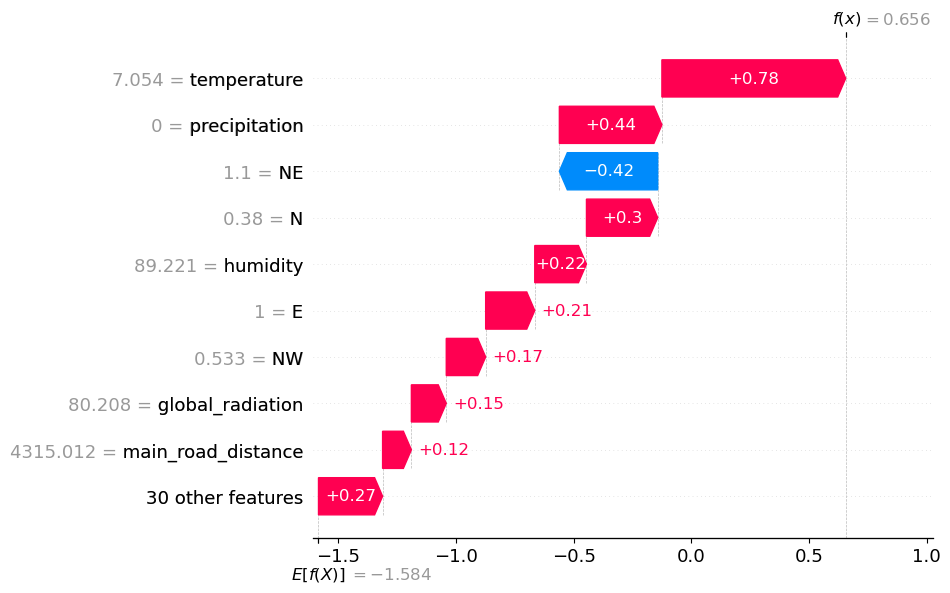

In [11]:
explainer = shap.Explainer(ai_model.model)
shap_values = explainer(ai_model.X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

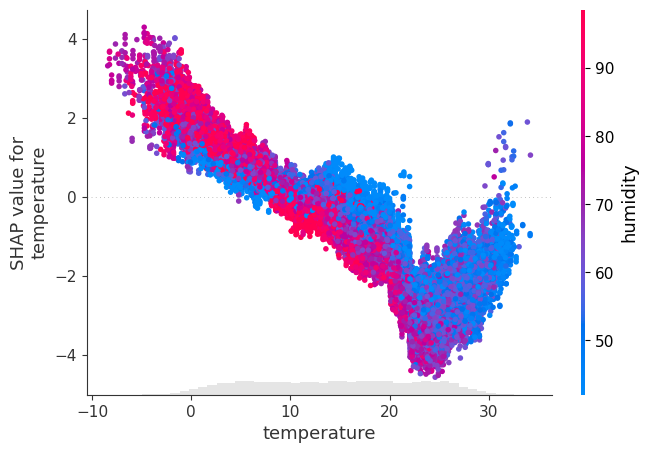

In [19]:
shap.plots.scatter(shap_values[:, "temperature"], color=shap_values)

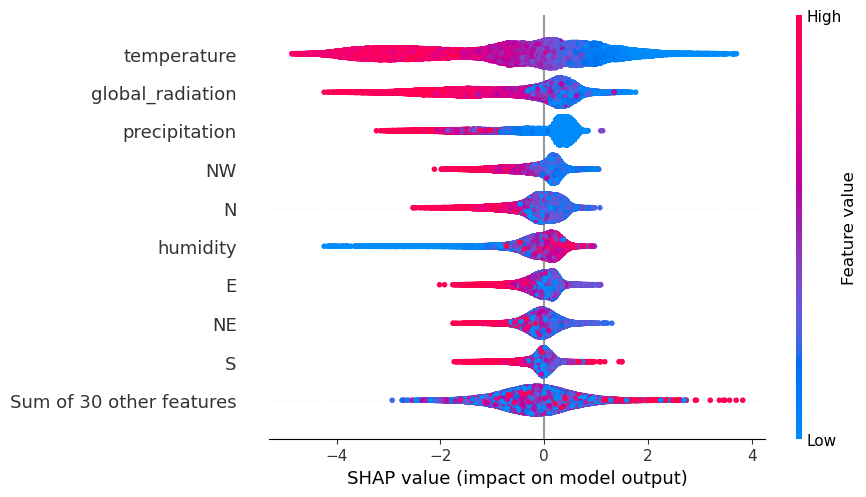

In [17]:
shap.plots.beeswarm(shap_values)

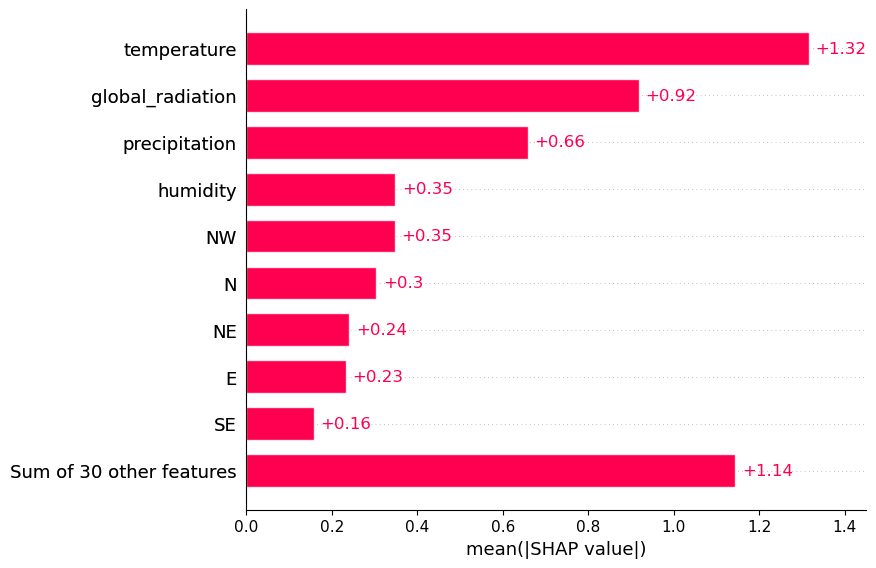

In [21]:
shap.plots.bar(shap_values)

In [6]:
#ai_model.trained_model
import shap

scaler = ai_model.scaler

train_shap = training_dataset.drop('exc',axis=1)
train_shap = scaler.transform(train_shap)
train_shap = train_shap.reshape((train_shap.shape[0], 1, train_shap.shape[1]))

test_shap = testing_dataset.drop('exc',axis=1)
test_shap = scaler.transform(test_shap)
test_shap = test_shap.reshape((test_shap.shape[0], 1, test_shap.shape[1]))

# Create the background data as 3D (for LSTM)
background_data = train_shap[:100]  # first 100 samples of original data

# Reshape the test data to 3D (samples, timesteps, features)
test_data = test_shap[:1]  # 10 samples of original test data



In [7]:
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [ ]:
# SHAP DeepExplainer for LSTM model (useful for deep learning models)
explainer = shap.DeepExplainer(ai_model.trained_model, background_data)

# Get SHAP values for the test data
shap_values = explainer.shap_values(test_data)

# Visualize the SHAP values for the first sample
shap.summary_plot(shap_values[0], test_data, feature_names=training_dataset.columns)

In [ ]:
import tensorflow as tf

train_X, train_y = next(iter(training_dataset))  # Fetch a batch from the dataset
scaler = ai_model.scaler

train_shap = train_X.drop('exc',axis=1)
train_shap = scaler.transform(train_shap)
train_shap = train_shap.reshape((train_shap.shape[0], 1, train_shap.shape[1]))


# Create the background data as 3D (for LSTM)
background_data = train_shap[:100]  # first 100 samples of original data

# Reshape the test data to 3D (samples, timesteps, features)
test_data = test_shap[:10]  # 10 samples of original test data
# Get the input tensor of the model
input_tensors = tf.convert_to_tensor(train_shap, dtype=tf.float32)

# Stop gradients for input if required (silence the error)
input_tensors = tf.stop_gradient(input_tensors)

# Get the gradient of the output with respect to the input
with tf.GradientTape() as tape:
    tape.watch(input_tensors)
    predictions = ai_model.trained_model.predict(input_tensors)
    loss = tf.reduce_max(predictions)  # or use specific output of interest

# Compute the gradients
grads = tape.gradient(loss, input_tensors)

# Get the absolute values of the gradients (for saliency)
saliency = tf.abs(grads)

In [ ]:
training_dataset.iloc[50]

In [ ]:
test_X_flat[50]

In [8]:
from lime import lime_tabular

# Flatten the time series data into 2D shape for LIME
train_X_flat = train_shap.reshape(train_shap.shape[0], -1)
test_X_flat = test_shap.reshape(test_shap.shape[0], -1)
# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    train_X_flat, 
    feature_names=list(training_dataset.drop('exc', axis=1).columns), 
    class_names=['no_exc','exc'], 
    mode='classification'  # or 'regression'
)

# Explain a prediction
explanation = explainer.explain_instance(
    test_X_flat[50], 
    ai_model.lime_predict, 
    labels=[1], 
    num_features=37
)

# Show the explanation
explanation.show_in_notebook()



(5000, 37)
157/157 [==============================] - 0s 372us/step


2024-10-16 09:45:55.860325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-16 09:45:55.860830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-16 09:45:55.861438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [9]:
explanation.save_to_file("expl.html")

In [ ]:
#Score the models
scores_df_columns = ["type", "train_mode", "pollutant", "prefix", "score"]
scores_df = pd.DataFrame(columns=scores_df_columns)

for model_to_use in models:
    prefix = model_options[model_to_use]['prefix']
    print(f"FOR {model_to_use}")

    for pollutant in pollutants:
        print(f"FOR {pollutant}")
        
        for training_mode in train_modes:
    
            train_path = f'../harmonia_processor/{pollutant}/train/training_{training_mode}.csv'
            training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
            training_dataset = training_dataset.dropna()
            training_dates = training_dataset.copy()[['date']]
            if 'date' in list(training_dataset.columns):
                training_dataset = training_dataset.drop(['date'], axis=1)

            test_path = f'../harmonia_processor/{pollutant}/train/validation_{training_mode}.csv'
            testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
            testing_dataset = testing_dataset.dropna()
            testing_dates = testing_dataset.copy()[['date']]
            if 'date' in list(testing_dataset.columns):
                testing_dataset = testing_dataset.drop(['date'], axis=1)

            #save the training columns for selecting them in the prediction dataset
            training_columns = list(training_dataset.columns)
            training_columns.remove('exc')
            
            model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{training_mode}.csv'
            ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
            ai_model.load_model(model_path)
            ai_model.model_type = model_to_use
        
            score = ai_model.score_model()
            score_row = [model_to_use, training_mode, pollutant, prefix, score]
            scores_df = pd.concat([
                scores_df, 
                pd.DataFrame(
                    [score_row], 
                    columns=scores_df_columns
                )
            ])
    
scores_path = f'../harmonia_processor/model_scores.csv'
scores_df.to_csv(scores_path)
scores_df

In [ ]:
#plot for model accuracies
for model in models:
    plot_dfs = []
    plot_names = []
    sort_by = 'train_mode'
    print(f"--------------------------------------------------")
    print(f"scores for model {model}")
    for pollutant in pollutants:
        temp_plot_df = scores_df.loc[
            (scores_df['pollutant'] == pollutant) & (scores_df['type'] == model)
        ].reset_index(drop=True).sort_values(by=sort_by)
        plot_dfs.append(temp_plot_df.copy())
        plot_names.append(pollutant)

    importer.show_plot(
        plot_dfs,
        ['train_mode', 'train_mode', 'train_mode', 'train_mode'],
        ['score', 'score', 'score', 'score'],
        plot_names
    )

In [ ]:
#calculate best models
scores_path = f'../harmonia_processor/model_scores.csv'
scores_df = importer.import_df(scores_path, date_format=None)
scores_df = scores_df.reset_index(drop=True)

best_model_data = {}
for pollutant in pollutants:
    best = scores_df.sort_values(by='score', ascending=False).loc[
        scores_df['pollutant'] == pollutant
    ].reset_index(drop=True).iloc[0]
    best_path = f'../harmonia_processor/{pollutant}/model/{best.prefix}_model_{best.train_mode}.csv'
    best_type = best.type
    best_model_data[pollutant] = {
        "model_path": best_path,
        "prefix": best.prefix,
        "train_mode": best.train_mode,
        "type": best_type,
        "score": best.score
    }
best_model_data

In [ ]:
#predict the stations and grid samples for each model, each month, each pollutant, for the best model score
best_base_path_predictions = f'../best_model/predictions'
for pollutant in pollutants:
    print(f"FOR {pollutant}")
    model_data = best_model_data[pollutant]
    train_mode = model_data['train_mode']
    prefix = model_data['prefix']
    model_to_use = model_data['type']
    
    train_path = f'../harmonia_processor/{pollutant}/train/training_{train_mode}.csv'
    training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
    training_dataset = training_dataset.dropna()
    training_dates = training_dataset.copy()[['date']]
    if 'date' in list(training_dataset.columns):
        training_dataset = training_dataset.drop(['date'], axis=1)

    test_path = f'../harmonia_processor/{pollutant}/train/validation_{train_mode}.csv'
    testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
    testing_dataset = testing_dataset.dropna()
    testing_dates = testing_dataset.copy()[['date']]
    if 'date' in list(testing_dataset.columns):
        testing_dataset = testing_dataset.drop(['date'], axis=1)

    #save the training columns for selecting them in the prediction dataset
    training_columns = list(training_dataset.columns)
    if 'exc' in training_columns:
        training_columns.remove('exc')

    model_path = f'../harmonia_processor/{pollutant}/model/{prefix}_model_{train_mode}.csv'
    ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
    ai_model.load_model(model_path)
    ai_model.model_type = model_to_use

    predictions = {}
    predictions_grid = {}
    predicts = {}
    predicts_grid = {}

    for m in range(1,13):
        print(f'FOR {pollutant} MONTH {m}')
        print(f"Predicting in stations datasets")
        predict_path = f'../harmonia_processor/{pollutant}/predict/stations_month_{m}.csv'
        prediction_df =  importer.import_df(predict_path, date_format=None)
        prediction_dataset = prediction_df.copy()
        prediction_dataset = prediction_dataset[training_columns]
        predicts[m] = prediction_df.copy()
        if 'date' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['date'], axis=1)

        prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
        if model_to_use == 'lstm':
            predicted_probabilities = ai_model.predict(
                prediction_dataset.copy(), 
                predict_options=model_options[model_to_use]['prediction_options']
            )
        else:
            predicted_probabilities = ai_model.predict_probabilities(
                prediction_dataset.copy(),
                predict_options=model_options[model_to_use]['prediction_options']
            )
            predicted_probabilities = predicted_probabilities[:,1]

        #Create a DF from predicted labels
        predicted_df = pd.DataFrame(predicted_probabilities)
        predicted_df.columns = ['exc']

        #Concat DF with UTM coordinates 
        predicted_df = predicted_df.reset_index(drop=True)
        prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
        predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
        predicted_df['exc'] = predicted_df['exc']*100

        predictions[m] = predicted_df.copy()

        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_stations_month_{m}.csv'
        predictions[m].to_csv(prediction_path)


        print(f"Predicting in grid datasets")
        predict_path = f'../harmonia_processor/{pollutant}/predict/grid_month_{m}.csv'
        prediction_df =  importer.import_df(predict_path, date_format=None)
        prediction_dataset = prediction_df.copy()
        prediction_dataset = prediction_dataset[training_columns]
        predicts_grid[m] = prediction_df.copy()
        if 'date' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['date'], axis=1)


        prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
        if model_to_use == 'lstm':
            predicted_probabilities = ai_model.predict(
                prediction_dataset.copy(), 
                predict_options=model_options[model_to_use]['prediction_options']
            )
        else:
            predicted_probabilities = ai_model.predict_probabilities(
                prediction_dataset.copy(), 
                predict_options=model_options[model_to_use]['prediction_options']
            )
            predicted_probabilities = predicted_probabilities[:,1]

        #Create a DF from predicted labels
        predicted_df = pd.DataFrame(predicted_probabilities)
        predicted_df.columns = ['exc']

        #Concat DF with UTM coordinates 
        #reset index to avoid indexing problems
        predicted_df = predicted_df.reset_index(drop=True)
        prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
        predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
        predicted_df['exc'] = predicted_df['exc']*100

        predictions_grid[m] = predicted_df.copy()

        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_grid_month_{m}.csv'
        predictions_grid[m].to_csv(prediction_path)


In [ ]:
milano_shapefile = '../data/milano_final_shapefile/milano_metro.shp'
milano_epsg = 32632
grid = interp.create_grid_from_shapefile(milano_shapefile, xdelta=1000, ydelta=1000, shapefile_epsg=milano_epsg)
pollutants = ['pm10', 'pm25', 'so2', 'o3']

In [ ]:
grid

In [ ]:
#Generate rasters with stations data
best_raster_base_path = f'../best_model/rasters'
for pollutant in pollutants:
    for m in range(1,13):
        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_stations_month_{m}.csv'
        prediction_m =  importer.import_df(prediction_path, date_format=None)
        print(f"------ {pollutant} --- month {m} ------")
        interpolated_to_grid,b = interp.interpolate(
            'exc', 
            'NN', 
            milano_shapefile,
            prediction_m.copy(), 
            visual_output=True,
            epsg_utm=milano_epsg
        )

        new_interp = pd.DataFrame()
        new_interp['y'] = interpolated_to_grid.original_centroids.y
        new_interp['x'] = interpolated_to_grid.original_centroids.x
        new_interp['value'] = interpolated_to_grid.NN
        interp_xar = new_interp.set_index(['y', 'x']).to_xarray()

        raster_path = f'{best_raster_base_path}/stations_{pollutant}_month_{m}.tiff'
        
        array_to_write = np.flip(np.flip(interp_xar.value.to_numpy()), axis=1)
        profile = {
            'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': -9999.0, 
            'width': int(len(interp_xar.x)), 
            'height': int(len(interp_xar.y)), 
            'count': 1, 
            'crs': rio.CRS.from_epsg(32632), 
            'transform': rio.Affine(1000.0, 0.0, int(interp_xar.x[0]), 0.0, -1000.0, int(interp_xar.y[-1])), 
            'tiled': False, 
            'interleave': 'band'
        }
        with rio.open(raster_path, 'w', **profile) as dest:
            dest.write(array_to_write, 1)
    
        #prediction_raster = interp.save_as_raster(new_interp, raster_path, crs=milano_epsg)
        print(f"saved raster to {raster_path}")
    

In [ ]:
#Generate rasters with grid data
best_raster_base_path = f'../best_model/rasters'
for pollutant in pollutants:
    for m in range(1,13):
        prediction_path = f'{best_base_path_predictions}/best_{pollutant}_grid_month_{m}.csv'
        prediction_m =  importer.import_df(prediction_path, date_format=None)
        print(f"------ {pollutant} --- month {m} ------")

        interpolated_to_grid,b = interp.interpolate(
            'exc', 
            'NN', 
            milano_shapefile, 
            prediction_m, 
            visual_output=True,
            epsg_utm=milano_epsg
        )

        new_interp = pd.DataFrame()
        new_interp['y'] = interpolated_to_grid.original_centroids.y
        new_interp['x'] = interpolated_to_grid.original_centroids.x
        new_interp['value'] = interpolated_to_grid.NN
        
        interp_xar = new_interp.set_index(['y', 'x']).to_xarray()

        raster_path = f'{best_raster_base_path}/grid_{pollutant}_month_{m}.tiff'
        
        array_to_write = np.flip(np.flip(interp_xar.value.to_numpy()), axis=1)
        profile = {
            'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': -9999.0, 
            'width': int(len(interp_xar.x)), 
            'height': int(len(interp_xar.y)), 
            'count': 1, 
            'crs': rio.CRS.from_epsg(32632), 
            'transform': rio.Affine(1000.0, 0.0, int(interp_xar.x[0]), 0.0, -1000.0, int(interp_xar.y[-1])), 
            'tiled': False, 
            'interleave': 'band'
        }
        with rio.open(raster_path, 'w', **profile) as dest:
            dest.write(array_to_write, 1)

        
        #prediction_raster = interp.save_as_raster(new_interp, raster_path, crs=milano_epsg)
        print(f"saved raster to {raster_path}")
    

In [ ]:
#PREDICT ALL!
best_base_path_predictions = f'../harmonia_processor'
for pollutant in pollutants:
    print(f"FOR {pollutant}")
    for model_to_use in models:
        print(f"FOR {model_to_use}")
        for train_mode in train_modes:
            print(f"FOR {train_mode}")
            prefix = model_options[model_to_use]['prefix']

            train_path = f'{best_base_path_predictions}/{pollutant}/train/training_{train_mode}.csv'
            training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
            training_dataset = training_dataset.dropna()
            training_dates = training_dataset.copy()[['date']]
            if 'date' in list(training_dataset.columns):
                training_dataset = training_dataset.drop(['date'], axis=1)

            test_path = f'{best_base_path_predictions}/{pollutant}/train/validation_{train_mode}.csv'
            testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
            testing_dataset = testing_dataset.dropna()
            testing_dates = testing_dataset.copy()[['date']]
            if 'date' in list(testing_dataset.columns):
                testing_dataset = testing_dataset.drop(['date'], axis=1)

            #save the training columns for selecting them in the prediction dataset
            training_columns = list(training_dataset.columns)
            if 'exc' in training_columns:
                training_columns.remove('exc')

            model_path = f'{best_base_path_predictions}/{pollutant}/model/{prefix}_model_{train_mode}.csv'
            ai_model = ai.MLProcessor(training_dataset.copy(), testing_dataset.copy())
            ai_model.load_model(model_path)
            ai_model.model_type = model_to_use

            predictions = {}
            predictions_grid = {}
            predicts = {}
            predicts_grid = {}

            for m in range(1,13):
                print(f'FOR {pollutant} MONTH {m}')
                print(f"Predicting in stations datasets")
                predict_path = f'{best_base_path_predictions}/{pollutant}/predict/stations_month_{m}.csv'
                prediction_df =  importer.import_df(predict_path, date_format=None)
                prediction_dataset = prediction_df.copy()
                prediction_dataset = prediction_dataset[training_columns]
                predicts[m] = prediction_df.copy()
                if 'date' in list(prediction_dataset.columns):
                    prediction_dataset = prediction_dataset.drop(['date'], axis=1)

                prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
                if model_to_use == 'lstm':
                    predicted_probabilities = ai_model.predict(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                else:
                    predicted_probabilities = ai_model.predict_probabilities(
                        prediction_dataset.copy(),
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                    predicted_probabilities = predicted_probabilities[:,1]

                #Create a DF from predicted labels
                predicted_df = pd.DataFrame(predicted_probabilities)
                predicted_df.columns = ['exc']

                #Concat DF with UTM coordinates 
                predicted_df = predicted_df.reset_index(drop=True)
                prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
                predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
                predicted_df['exc'] = predicted_df['exc']*100

                predictions[m] = predicted_df.copy()

                prediction_path = f'{best_base_path_predictions}/{pollutant}/predictions/{prefix}_prediction_month_{m}_stations_{train_mode}.csv'
                predictions[m].to_csv(prediction_path)


                print(f"Predicting in grid datasets")
                predict_path = f'{best_base_path_predictions}/{pollutant}/predict/grid_month_{m}.csv'
                prediction_df =  importer.import_df(predict_path, date_format=None)
                prediction_dataset = prediction_df.copy()
                prediction_dataset = prediction_dataset[training_columns]
                predicts_grid[m] = prediction_df.copy()
                if 'date' in list(prediction_dataset.columns):
                    prediction_dataset = prediction_dataset.drop(['date'], axis=1)


                prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
                if model_to_use == 'lstm':
                    predicted_probabilities = ai_model.predict(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                else:
                    predicted_probabilities = ai_model.predict_probabilities(
                        prediction_dataset.copy(), 
                        predict_options=model_options[model_to_use]['prediction_options']
                    )
                    predicted_probabilities = predicted_probabilities[:,1]

                #Create a DF from predicted labels
                predicted_df = pd.DataFrame(predicted_probabilities)
                predicted_df.columns = ['exc']

                #Concat DF with UTM coordinates 
                #reset index to avoid indexing problems
                predicted_df = predicted_df.reset_index(drop=True)
                prediction_locations = prediction_dataset[['lat','lng']].reset_index(drop=True)
                predicted_df = pd.concat([predicted_df, prediction_locations],axis=1)
                predicted_df['exc'] = predicted_df['exc']*100

                predictions_grid[m] = predicted_df.copy()

                prediction_path = f'{best_base_path_predictions}/{pollutant}/predictions/{prefix}_prediction_month_{m}_grid_{train_mode}.csv'
                predictions_grid[m].to_csv(prediction_path)
